In [2]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error


In [3]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

# Config

In [4]:
directory = os.path.dirname(os.path.dirname(os.getcwd()))

In [5]:
test_datafile = '/data/project/general/aerosolretriev/aerosol_data/dataset_22_11_2022/data_all_test_iv.h5'
#'/data/project/general/aerosolretriev/aerosol_data/dataset_09_11_2022/data_all_test_iv.h5'

In [6]:
model_name = 'forward_model/surrogate_model'

In [7]:
model_dir = '/data/project/general/aerosolretriev/aerosol_results_november_2022/results_27_11_2022/forward_model_iv_2/models'


In [8]:
plot_dir = model_dir +'/plots/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Load the model and the data

In [9]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

surr = KerasSurrogate.load(model_dir, model_name, model_kwargs=kwargs)
#import tensorflow as tf
#tf.keras.backend.set_floatx('float32')
#surr = KerasSurrogate.load(model_dir, model_name)

In [10]:
dir(surr)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_surrogate',
 '_fit_model',
 '_load_model',
 '_model',
 '_name',
 '_predict_model',
 '_save_model',
 '_version',
 'details',
 'fit',
 'load',
 'model',
 'name',
 'predict',
 'preprocessor_x',
 'preprocessor_y',
 'save',
 'version']

In [145]:
dvar_test = pd.read_hdf(test_datafile,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile,key = 'qoi')

dvar = pd.read_hdf(datafile, key='dvar')
qoi = pd.read_hdf(datafile, key='qoi')

n_in = dvar.shape[1]

dvar_trainval, dvar_test, qoi_trainval, qoi_test = train_test_split(dvar,
                                                                    qoi,
                                                                    test_size=0.2)
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True, inplace=True)

dvar_trainval.reset_index(drop=True, inplace=True)
qoi_trainval.reset_index(drop=True, inplace=True)

kf = KFold(n_splits=5, random_state=76, shuffle=True)

train_ind, val_ind = next(kf.split(dvar_trainval))

dvar_train = dvar_trainval.values[train_ind]
dvar_val = dvar_trainval.values[val_ind]
qoi_train = qoi_trainval.values[train_ind]
qoi_val = qoi_trainval.values[val_ind]

In [12]:
dvar_test

Vtot  RmedianV       GSD         n         k
0       2.566133  8.269344  0.414940 -0.326547  0.267465
1       5.531172  6.261997  0.679891 -0.445321 -1.193788
2       2.593518  5.140769 -0.399165 -0.120338 -0.521751
3       7.992243  5.090128  0.620608  0.242951 -0.366268
4       1.515778  6.717380 -1.165973 -0.443211 -1.640339
...          ...       ...       ...       ...       ...
200622  8.425457  7.345743 -0.753785 -1.202656  0.446458
200623  8.386286  5.983967 -0.207708  0.506847  0.232190
200624  1.713304  8.179556 -0.506422  0.116362  0.572672
200625  4.897825  7.499241  0.605485  0.330635 -0.101508
200626  2.981877  4.765291 -0.617848  0.186870  0.617161

[200627 rows x 5 columns]

In [13]:
qoi_test

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0       1.849627  1.606297  1.380296  1.169623  0.972640  0.787980  0.614495   
1       6.628660  6.530736  6.436893  6.346727  6.259893  6.176093  6.095069   
2       3.753348  3.732465  3.710022  3.686108  3.660808  3.634204  3.606380   
3       8.992801  8.946110  8.899912  8.854235  8.809095  8.764502  8.720455   
4       2.772375  2.559648  2.332314  2.092193  1.841557  1.583258  1.320877   
...          ...       ...       ...       ...       ...       ...       ...   
200622  8.494608  8.151921  7.836840  7.553027  7.301177  7.079378  6.883997   
200623  9.741480  9.663413  9.583731  9.502881  9.421238  9.339119  9.256789   
200624 -0.009030 -0.281812 -0.522337 -0.737506 -0.932055 -1.109268 -1.271499   
200625  5.268869  5.093596  4.928592  4.772670  4.624858  4.484347  4.350458   
200626  3.889094  3.878964  3.867947  3.856064  3.843334  3.829780  3.815426   

          F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163  \
0       0.451206  0.297266  0.151948  ...  0.020661  0.018675  0.016788   
1       6.016597  5.940477  5.866535  ...  0.068337  0.063213  0.058022   
2       3.577413  3.547381  3.516358  ...  0.062548  0.056812  0.051247   
3       8.676948  8.633973  8.591521  ...  0.053980  0.048672  0.043606   
4       1.058812  0.802238  0.556842  ...  0.019644  0.018876  0.018432   
...          ...       ...       ...  ...       ...       ...       ...   
200622  6.710707  6.555307  6.414196  ...  0.017990  0.016136  0.014389   
200623  9.174478  9.092379  9.010660  ...  0.032240  0.029740  0.027248   
200624 -1.420516 -1.557711 -1.684229  ...  0.014924  0.013384  0.011930   
200625  4.222616  4.100327  3.983163  ...  0.027269  0.024901  0.022604   
200626  3.800296  3.784414  3.767807  ...  0.042345  0.038157  0.034164   

         PPF_164   PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0       0.014998  0.013304  0.011706  0.010204  0.008796  0.007482  0.006262  
1       0.052804  0.047604  0.042464  0.037432  0.032552  0.027870  0.023430  
2       0.045875  0.040718  0.035796  0.031127  0.026730  0.022621  0.018817  
3       0.038789  0.034227  0.029927  0.025895  0.022137  0.018658  0.015463  
4       0.018217  0.018120  0.018022  0.017807  0.017374  0.016644  0.015570  
...          ...       ...       ...       ...       ...       ...       ...  
200622  0.012750  0.011218  0.009793  0.008473  0.007257  0.006141  0.005123  
200623  0.024774  0.022331  0.019931  0.017591  0.015324  0.013149  0.011082  
200624  0.010562  0.009279  0.008077  0.006961  0.005930  0.004985  0.004121  
200625  0.020380  0.018233  0.016168  0.014190  0.012305  0.010519  0.008842  
200626  0.030371  0.026782  0.023404  0.020238  0.017291  0.014565  0.012065  

[200627 rows x 304 columns]

In [14]:
qoi_test = qoi_test.reset_index(drop = True)
qoi_test

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0       1.849627  1.606297  1.380296  1.169623  0.972640  0.787980  0.614495   
1       6.628660  6.530736  6.436893  6.346727  6.259893  6.176093  6.095069   
2       3.753348  3.732465  3.710022  3.686108  3.660808  3.634204  3.606380   
3       8.992801  8.946110  8.899912  8.854235  8.809095  8.764502  8.720455   
4       2.772375  2.559648  2.332314  2.092193  1.841557  1.583258  1.320877   
...          ...       ...       ...       ...       ...       ...       ...   
200622  8.494608  8.151921  7.836840  7.553027  7.301177  7.079378  6.883997   
200623  9.741480  9.663413  9.583731  9.502881  9.421238  9.339119  9.256789   
200624 -0.009030 -0.281812 -0.522337 -0.737506 -0.932055 -1.109268 -1.271499   
200625  5.268869  5.093596  4.928592  4.772670  4.624858  4.484347  4.350458   
200626  3.889094  3.878964  3.867947  3.856064  3.843334  3.829780  3.815426   

          F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163  \
0       0.451206  0.297266  0.151948  ...  0.020661  0.018675  0.016788   
1       6.016597  5.940477  5.866535  ...  0.068337  0.063213  0.058022   
2       3.577413  3.547381  3.516358  ...  0.062548  0.056812  0.051247   
3       8.676948  8.633973  8.591521  ...  0.053980  0.048672  0.043606   
4       1.058812  0.802238  0.556842  ...  0.019644  0.018876  0.018432   
...          ...       ...       ...  ...       ...       ...       ...   
200622  6.710707  6.555307  6.414196  ...  0.017990  0.016136  0.014389   
200623  9.174478  9.092379  9.010660  ...  0.032240  0.029740  0.027248   
200624 -1.420516 -1.557711 -1.684229  ...  0.014924  0.013384  0.011930   
200625  4.222616  4.100327  3.983163  ...  0.027269  0.024901  0.022604   
200626  3.800296  3.784414  3.767807  ...  0.042345  0.038157  0.034164   

         PPF_164   PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0       0.014998  0.013304  0.011706  0.010204  0.008796  0.007482  0.006262  
1       0.052804  0.047604  0.042464  0.037432  0.032552  0.027870  0.023430  
2       0.045875  0.040718  0.035796  0.031127  0.026730  0.022621  0.018817  
3       0.038789  0.034227  0.029927  0.025895  0.022137  0.018658  0.015463  
4       0.018217  0.018120  0.018022  0.017807  0.017374  0.016644  0.015570  
...          ...       ...       ...       ...       ...       ...       ...  
200622  0.012750  0.011218  0.009793  0.008473  0.007257  0.006141  0.005123  
200623  0.024774  0.022331  0.019931  0.017591  0.015324  0.013149  0.011082  
200624  0.010562  0.009279  0.008077  0.006961  0.005930  0.004985  0.004121  
200625  0.020380  0.018233  0.016168  0.014190  0.012305  0.010519  0.008842  
200626  0.030371  0.026782  0.023404  0.020238  0.017291  0.014565  0.012065  

[200627 rows x 304 columns]

In [15]:
dvar_test = dvar_test.reset_index(drop = True)
dvar_test

Vtot  RmedianV       GSD         n         k
0       2.566133  8.269344  0.414940 -0.326547  0.267465
1       5.531172  6.261997  0.679891 -0.445321 -1.193788
2       2.593518  5.140769 -0.399165 -0.120338 -0.521751
3       7.992243  5.090128  0.620608  0.242951 -0.366268
4       1.515778  6.717380 -1.165973 -0.443211 -1.640339
...          ...       ...       ...       ...       ...
200622  8.425457  7.345743 -0.753785 -1.202656  0.446458
200623  8.386286  5.983967 -0.207708  0.506847  0.232190
200624  1.713304  8.179556 -0.506422  0.116362  0.572672
200625  4.897825  7.499241  0.605485  0.330635 -0.101508
200626  2.981877  4.765291 -0.617848  0.186870  0.617161

[200627 rows x 5 columns]

In [16]:
dvar_test.columns

Index(['Vtot', 'RmedianV', 'GSD', 'n', 'k'], dtype='object')

In [17]:
qoi_columns = qoi_test.columns
qoi_columns

Index(['F11_10', 'F11_11', 'F11_12', 'F11_13', 'F11_14', 'F11_15', 'F11_16',
       'F11_17', 'F11_18', 'F11_19',
       ...
       'PPF_161', 'PPF_162', 'PPF_163', 'PPF_164', 'PPF_165', 'PPF_166',
       'PPF_167', 'PPF_168', 'PPF_169', 'PPF_170'],
      dtype='object', length=304)

# Predict

In [18]:
qoi_pred = surr.predict(dvar_test)
qoi_pred = pd.DataFrame(data=qoi_pred, columns=qoi_test.columns)

In [19]:
qoi_pred

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0       1.862719  1.616028  1.388087  1.175797  0.977003  0.790688  0.615864   
1       6.629052  6.526268  6.427828  6.336652  6.249067  6.163503  6.081892   
2       3.781690  3.754605  3.727663  3.701024  3.671501  3.641001  3.606892   
3       8.981276  8.931498  8.884426  8.840957  8.796417  8.751050  8.705306   
4       2.776275  2.535348  2.285656  2.030458  1.775184  1.520369  1.267615   
...          ...       ...       ...       ...       ...       ...       ...   
200622  8.483155  8.150393  7.835657  7.546381  7.289882  7.064785  6.866985   
200623  9.734265  9.656961  9.577638  9.497068  9.414007  9.329025  9.243038   
200624 -0.012737 -0.278368 -0.514406 -0.731864 -0.931079 -1.112304 -1.277432   
200625  5.256957  5.085159  4.921888  4.767176  4.619367  4.478836  4.343933   
200626  3.878778  3.868860  3.859999  3.848774  3.835386  3.820823  3.804909   

          F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163  \
0       0.452715  0.299405  0.155782  ...  0.020327  0.018339  0.016402   
1       6.003311  5.928096  5.856747  ...  0.070261  0.064745  0.059468   
2       3.574242  3.543469  3.512392  ...  0.060675  0.055165  0.049673   
3       8.660555  8.617806  8.576732  ...  0.054312  0.049166  0.044198   
4       1.018696  0.778863  0.556322  ...  0.027460  0.025145  0.022880   
...          ...       ...       ...  ...       ...       ...       ...   
200622  6.692614  6.539095  6.403038  ...  0.017441  0.015786  0.014138   
200623  9.157536  9.074922  8.993595  ...  0.030980  0.028804  0.026467   
200624 -1.427080 -1.562987 -1.686449  ...  0.015059  0.013645  0.012225   
200625  4.217537  4.099177  3.985616  ...  0.026173  0.024027  0.021826   
200626  3.789284  3.775257  3.762254  ...  0.043382  0.039164  0.035093   

         PPF_164   PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0       0.014602  0.012735  0.011120  0.009424  0.007893  0.006452  0.005173  
1       0.054047  0.048635  0.043263  0.038421  0.033475  0.028658  0.023988  
2       0.044457  0.039435  0.034591  0.029704  0.025082  0.020693  0.016631  
3       0.039515  0.035030  0.030761  0.026692  0.022767  0.018962  0.015439  
4       0.021277  0.019869  0.018438  0.017640  0.016510  0.015176  0.013868  
...          ...       ...       ...       ...       ...       ...       ...  
200622  0.012806  0.011587  0.010565  0.009416  0.008357  0.007277  0.006217  
200623  0.024092  0.021818  0.019510  0.017238  0.014997  0.012868  0.010910  
200624  0.011048  0.009818  0.008719  0.007591  0.006561  0.005598  0.004794  
200625  0.019792  0.017809  0.015988  0.014105  0.012258  0.010446  0.008760  
200626  0.031362  0.027776  0.024419  0.021112  0.017875  0.014830  0.011891  

[200627 rows x 304 columns]

In [20]:
qoi_test

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0       1.849627  1.606297  1.380296  1.169623  0.972640  0.787980  0.614495   
1       6.628660  6.530736  6.436893  6.346727  6.259893  6.176093  6.095069   
2       3.753348  3.732465  3.710022  3.686108  3.660808  3.634204  3.606380   
3       8.992801  8.946110  8.899912  8.854235  8.809095  8.764502  8.720455   
4       2.772375  2.559648  2.332314  2.092193  1.841557  1.583258  1.320877   
...          ...       ...       ...       ...       ...       ...       ...   
200622  8.494608  8.151921  7.836840  7.553027  7.301177  7.079378  6.883997   
200623  9.741480  9.663413  9.583731  9.502881  9.421238  9.339119  9.256789   
200624 -0.009030 -0.281812 -0.522337 -0.737506 -0.932055 -1.109268 -1.271499   
200625  5.268869  5.093596  4.928592  4.772670  4.624858  4.484347  4.350458   
200626  3.889094  3.878964  3.867947  3.856064  3.843334  3.829780  3.815426   

          F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163  \
0       0.451206  0.297266  0.151948  ...  0.020661  0.018675  0.016788   
1       6.016597  5.940477  5.866535  ...  0.068337  0.063213  0.058022   
2       3.577413  3.547381  3.516358  ...  0.062548  0.056812  0.051247   
3       8.676948  8.633973  8.591521  ...  0.053980  0.048672  0.043606   
4       1.058812  0.802238  0.556842  ...  0.019644  0.018876  0.018432   
...          ...       ...       ...  ...       ...       ...       ...   
200622  6.710707  6.555307  6.414196  ...  0.017990  0.016136  0.014389   
200623  9.174478  9.092379  9.010660  ...  0.032240  0.029740  0.027248   
200624 -1.420516 -1.557711 -1.684229  ...  0.014924  0.013384  0.011930   
200625  4.222616  4.100327  3.983163  ...  0.027269  0.024901  0.022604   
200626  3.800296  3.784414  3.767807  ...  0.042345  0.038157  0.034164   

         PPF_164   PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0       0.014998  0.013304  0.011706  0.010204  0.008796  0.007482  0.006262  
1       0.052804  0.047604  0.042464  0.037432  0.032552  0.027870  0.023430  
2       0.045875  0.040718  0.035796  0.031127  0.026730  0.022621  0.018817  
3       0.038789  0.034227  0.029927  0.025895  0.022137  0.018658  0.015463  
4       0.018217  0.018120  0.018022  0.017807  0.017374  0.016644  0.015570  
...          ...       ...       ...       ...       ...       ...       ...  
200622  0.012750  0.011218  0.009793  0.008473  0.007257  0.006141  0.005123  
200623  0.024774  0.022331  0.019931  0.017591  0.015324  0.013149  0.011082  
200624  0.010562  0.009279  0.008077  0.006961  0.005930  0.004985  0.004121  
200625  0.020380  0.018233  0.016168  0.014190  0.012305  0.010519  0.008842  
200626  0.030371  0.026782  0.023404  0.020238  0.017291  0.014565  0.012065  

[200627 rows x 304 columns]

In [21]:
F11_columns = [x for x in qoi_test.columns if 'F11' in x]
PPF_columns = [x for x in qoi_test.columns if 'PPF' in x]

In [22]:
qoi_test[F11_columns] = np.exp(qoi_test[F11_columns])
qoi_pred[F11_columns] = np.exp(qoi_pred[F11_columns])


# Calculate metrics

In [23]:
res = qoi_test - qoi_pred

q = np.arange(0.1, 1.0, 0.05)
q = np.append(q, [0.98, 0.99])
q = np.round(q, decimals=3)
quantiles = res.abs().quantile(q)
quantiles.to_csv(f'{plot_dir}/forward_prediction_residual_quantiles_by_longitudinal_pos.csv', sep='\t')

## R2 


Use either R2 or adjusted R2

R2 = 1 - residual_sum_of_squares / total_sum_of_squares =  $1- \frac{\sum{(y_{true}-y_{pred})^2}}{ \sum{(y_{true}-\bar{y}_{true})}}$


adjusted R2 = $1- \frac{(1-R2)(n-1)}{n-k-1}$

In [164]:
#metric = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])
metric = RSquaredSeparated()
r2_adj = metric.call(qoi_test.values, qoi_pred.values).numpy()
r2_adj = pd.Series(data=r2_adj, index=qoi_test.columns)
r2_adj = np.round(r2_adj, decimals=2)
r2_adj = pd.DataFrame(r2_adj).T
print('Forward model: ','R2_min = ', min(r2_adj.min()),';  R2_max = ', max(r2_adj.max()))
r2_adj

Forward model:  R2_min =  -1551019.13 ;  R2_max =  1.0


F11_10      F11_11      F11_12     F11_13     F11_14     F11_15  \
0 -1551019.13 -1279091.48 -1072880.79 -911284.87 -778641.21 -668435.88   

      F11_16     F11_17     F11_18     F11_19  ...  PPF_161  PPF_162  PPF_163  \
0 -576751.87 -502374.32 -441765.17 -391222.58  ...     0.96     0.96     0.96   

   PPF_164  PPF_165  PPF_166  PPF_167  PPF_168  PPF_169  PPF_170  
0     0.96     0.95     0.95     0.95     0.94     0.94     0.92  

[1 rows x 302 columns]

In [37]:
r2_adj.values

array([[  1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,
          1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,
          1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,
          1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,
          1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,
          1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,
          1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,
          1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,
          1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,
          1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,
          1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,
          1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,
          1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,
          1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  , 

# Relative and absolute error

rel_error = $\frac{y_{true}-y_{pred}}{y_{true}}$

absolute_error = $|y_{true}-y_{pred}|$

be careful, if $y_{true}$ is very small

In [38]:
abs_error = np.abs(qoi_pred - qoi_test)
abs_error

F11_10      F11_11      F11_12     F11_13     F11_14      F11_15  \
0         0.083779    0.048741    0.031098   0.019945   0.011566    0.005962   
1         0.296733    3.057860    5.635007   5.720267   5.633146    6.018874   
2         1.226446    0.935373    0.727087   0.599440   0.418123    0.258285   
3        92.185769  111.369805  112.656843  92.384269  84.339260   85.556956   
4         0.062512    0.310449    0.469618   0.485093   0.404983    0.296885   
...            ...         ...         ...        ...        ...         ...   
200622   55.663900    5.297446    2.994342  12.627957  16.644961   17.198581   
200623  122.271856  101.184019   88.250921  77.665999  88.976720  114.225943   
200624    0.003667    0.002603    0.004723   0.002706   0.000385    0.001000   
200625    2.299695    1.369222    0.923274   0.647826   0.558469    0.487036   
200626    0.501512    0.486306    0.378778   0.343365   0.369524    0.410651   

            F11_16      F11_17      F11_18      F11_19  ...   PPF_161  \
0         0.002532    0.002371    0.002882    0.004471  ...  0.000333   
1         5.807898    5.413438    4.677441    3.438796  ...  0.001924   
2         0.018858    0.113305    0.135595    0.133256  ...  0.001873   
3        92.118502   95.375081   90.120410   79.065525  ...  0.000333   
4         0.194337    0.113362    0.051533    0.000908  ...  0.007816   
...            ...         ...         ...         ...  ...       ...   
200622   16.472338   14.723569   11.304817    6.773226  ...  0.000548   
200623  143.061192  162.073318  153.795705  138.578965  ...  0.001260   
200624    0.001659    0.001581    0.001108    0.000412  ...  0.000136   
200625    0.504145    0.345630    0.069366    0.131821  ...  0.001097   
200626    0.474943    0.489682    0.401153    0.239701  ...  0.001037   

         PPF_162   PPF_163   PPF_164   PPF_165   PPF_166   PPF_167   PPF_168  \
0       0.000336  0.000386  0.000397  0.000569  0.000586  0.000780  0.000903   
1       0.001532  0.001446  0.001242  0.001031  0.000799  0.000990  0.000923   
2       0.001647  0.001574  0.001418  0.001283  0.001205  0.001423  0.001648   
3       0.000494  0.000592  0.000726  0.000803  0.000834  0.000797  0.000630   
4       0.006269  0.004448  0.003060  0.001749  0.000416  0.000167  0.000864   
...          ...       ...       ...       ...       ...       ...       ...   
200622  0.000350  0.000251  0.000056  0.000369  0.000772  0.000943  0.001100   
200623  0.000937  0.000781  0.000682  0.000512  0.000421  0.000352  0.000328   
200624  0.000261  0.000295  0.000486  0.000540  0.000641  0.000630  0.000631   
200625  0.000874  0.000778  0.000588  0.000424  0.000180  0.000085  0.000047   
200626  0.001007  0.000929  0.000992  0.000994  0.001016  0.000873  0.000583   

         PPF_169   PPF_170  
0       0.001030  0.001090  
1       0.000788  0.000558  
2       0.001929  0.002185  
3       0.000304  0.000025  
4       0.001467  0.001702  
...          ...       ...  
200622  0.001136  0.001094  
200623  0.000281  0.000172  
200624  0.000614  0.000673  
200625  0.000073  0.000081  
200626  0.000264  0.000174  

[200627 rows x 304 columns]

In [39]:
rel_error = abs_error / qoi_test * 100.
rel_error = pd.DataFrame(rel_error, columns=qoi_test.columns).abs()
rel_error

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0       1.317808  0.977877  0.782137  0.619275  0.437285  0.271152  0.136963   
1       0.039226  0.445815  0.902376  1.002462  1.076748  1.251043  1.309073   
2       2.874684  2.238700  1.779688  1.502760  1.075067  0.682001  0.051199   
3       1.145882  1.450512  1.536650  1.319024  1.259762  1.336227  1.503492   
4       0.390784  2.400760  4.558623  5.986834  6.421837  6.095202  5.186887   
...          ...       ...       ...       ...       ...       ...       ...   
200622  1.138708  0.152662  0.118251  0.662362  1.123110  1.448632  1.686838   
200623  0.718878  0.643198  0.607516  0.579672  0.720584  1.004239  1.365681   
200624  0.370045  0.345002  0.796268  0.565749  0.097690  0.303154  0.591532   
200625  1.184211  0.840143  0.668144  0.547916  0.547582  0.549583  0.650393   
200626  1.026289  1.005302  0.791692  0.726255  0.791597  0.891703  1.046220   

          F11_17    F11_18    F11_19  ...    PPF_161    PPF_162    PPF_163  \
0       0.151020  0.214081  0.384113  ...   1.612441   1.799459   2.298291   
1       1.319770  1.230529  0.974098  ...   2.816048   2.422802   2.491558   
2       0.316663  0.390514  0.395868  ...   2.994497   2.898495   3.071947   
3       1.625865  1.603749  1.468036  ...   0.616242   1.014432   1.357752   
4       3.932172  2.310357  0.052011  ...  39.785903  33.211105  24.130470   
...          ...       ...       ...  ...        ...        ...        ...   
200622  1.793040  1.608162  1.109547  ...   3.048118   2.166790   1.744010   
200623  1.679912  1.730511  1.692066  ...   3.909381   3.149917   2.866517   
200624  0.654267  0.526228  0.221756  ...   0.908484   1.946842   2.471502   
200625  0.506701  0.114921  0.245539  ...   4.022014   3.510314   3.440621   
200626  1.095132  0.911506  0.553773  ...   2.448233   2.639968   2.719468   

          PPF_164   PPF_165   PPF_166    PPF_167    PPF_168    PPF_169  \
0        2.646579  4.279143  5.006875   7.642998  10.260755  13.768338   
1        2.353018  2.166613  1.882028   2.643730   2.836081   2.827564   
2        3.091659  3.151438  3.365690   4.572559   6.165311   8.525716   
3        1.871933  2.347037  2.787885   3.076354   2.843771   1.627954   
4       16.797926  9.652301  2.309041   0.938148   4.971333   8.816817   
...           ...       ...       ...        ...        ...        ...   
200622   0.442355  3.292733  7.887454  11.126632  15.151484  18.495077   
200623   2.751294  2.293872  2.111425   2.002238   2.137373   2.135057   
200624   4.597572  5.814501  7.936427   9.050824  10.649002  12.315179   
200625   2.883923  2.326711  1.114058   0.597954   0.378671   0.694009   
200626   3.264847  3.709752  4.340312   4.315829   3.373822   1.813099   

          PPF_170  
0       17.403674  
1        2.382241  
2       11.613931  
3        0.159930  
4       10.931009  
...           ...  
200622  21.358363  
200623   1.549447  
200624  16.321529  
200625   0.918968  
200626   1.438747  

[200627 rows x 304 columns]

In [40]:
abs_error_table =  np.round(abs_error.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
50%    1.21    0.92    0.75    0.63    0.55    0.48    0.45    0.42    0.37   
75%   10.97    8.40    7.03    5.96    5.15    4.69    4.58    4.39    3.90   
90%   52.94   41.51   35.27   30.69   27.47   25.59   25.94   25.29   22.75   
95%  109.17   86.71   75.22   66.98   60.59   56.80   57.20   56.26   51.32   
99%  317.62  249.68  223.45  206.84  192.50  179.80  173.67  168.29  157.13   

     F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  PPF_166  \
50%    0.32  ...     0.00     0.00     0.00     0.00     0.00     0.00   
75%    3.34  ...     0.00     0.00     0.00     0.00     0.00     0.00   
90%   19.89  ...     0.00     0.00     0.00     0.00     0.00     0.00   
95%   45.61  ...     0.01     0.01     0.00     0.00     0.00     0.00   
99%  147.07  ...     0.02     0.02     0.02     0.02     0.02     0.01   

     PPF_167  PPF_168  PPF_169  PPF_170  
50%     0.00     0.00     0.00     0.00  
75%     0.00     0.00     0.00     0.00  
90%     0.00     0.00     0.00     0.00  
95%     0.00     0.00     0.00     0.00  
99%     0.01     0.01     0.01     0.01  

[5 rows x 304 columns]

In [41]:
rel_error_table = np.round(rel_error.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
50%    1.14    1.00    0.94    0.89    0.86    0.86    0.93    0.97    0.94   
75%    2.10    1.83    1.75    1.69    1.63    1.62    1.68    1.73    1.71   
90%    3.68    3.14    3.09    3.06    2.99    2.92    2.93    2.94    2.90   
95%    5.26    4.42    4.48    4.53    4.51    4.31    4.23    4.15    4.10   
99%   11.95   10.26   10.74   10.80   10.97    9.97    9.20    9.15    9.22   

     F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  PPF_166  \
50%    0.89  ...     2.14     2.18     2.31     2.46     2.62     2.98   
75%    1.64  ...     4.27     4.51     4.84     5.23     5.53     6.12   
90%    2.80  ...     8.23     8.72     9.35    10.05    10.62    11.63   
95%    4.01  ...    15.02    15.61    16.24    16.74    17.47    18.59   
99%    9.58  ...    66.97    70.04    70.79    73.47    73.69    75.96   

     PPF_167  PPF_168  PPF_169  PPF_170  
50%     3.21     3.38     3.64     4.44  
75%     6.46     7.03     7.99     9.84  
90%    12.11    13.47    15.40    18.63  
95%    19.15    21.05    23.93    28.76  
99%    76.59    77.63    81.93    92.58  

[5 rows x 304 columns]

In [71]:
abs_error_table.loc['95%'].values


abs_error_table_test = abs_error_table.copy()
abs_error_table_test = abs_error_table_test.drop(['F11_141','PPF_19'], axis =1)

In [66]:
rel_error_table[P11_532_columns].loc['95%'].values




rel_error_table_test = rel_error_table.copy()
rel_error_table_test = rel_error_table_test.drop(['F11_141','PPF_19'], axis =1)

In [42]:
# if P11 and P12 are used:
P11_532_columns = []
P12_532_columns = []
for name in qoi_columns:
    if 'F11' in name:
        P11_532_columns.append(name)
    if 'PPF' in name:
        P12_532_columns.append(name)
abs_error_table_P11 = abs_error_table[P11_532_columns]
print('Absolute error P11')
print(abs_error_table_P11.max(axis = 1))
abs_error_table_P12 = abs_error_table[P12_532_columns]
print('Absolute error P11/P12')
print(abs_error_table_P12.max(axis = 1))
rel_error_table_P11 = rel_error_table_P11[P11_532_columns][rel_error_table[P11_532_columns]<99]
print('Relative error P11')
print(rel_error_table_P11.max(axis = 1))
rel_error_table_P12 = rel_error_table[P12_532_columns]
print('Relative error P11/P12')
print(rel_error_table_P12.max(axis = 1))


Absolute error P11
50%      2.22
75%     19.31
90%     99.01
95%    228.71
99%    729.62
dtype: float64
Absolute error P11/P12
50%    0.40
75%    0.51
90%    0.64
95%    0.71
99%    0.82
dtype: float64
Relative error P11
50%     99.98
75%    100.00
90%    100.00
95%    100.00
99%    100.00
dtype: float64
Relative error P11/P12
50%     339.53
75%     540.18
90%    1005.77
95%    1751.91
99%    7454.38
dtype: float64


In [72]:
# if P11 and P12 are used:
print('removing the outliers')
P11_532_columns_test = []
P12_532_columns_test = []
for name in rel_error_table_test.columns:
    if 'F11' in name:
        P11_532_columns_test.append(name)
    if 'PPF' in name:
        P12_532_columns_test.append(name)
abs_error_table_P11 = abs_error_table_test[P11_532_columns_test]
print('Absolute error P11')
print(abs_error_table_P11.max(axis = 1))
abs_error_table_P12 = abs_error_table_test[P12_532_columns_test]
print('Absolute error P11/P12')
print(abs_error_table_P12.max(axis = 1))
rel_error_table_P11 = rel_error_table_test[P11_532_columns_test]
print('Relative error P11')
print(rel_error_table_P11.max(axis = 1))
rel_error_table_P12 = rel_error_table_test[P12_532_columns_test]
print('Relative error P11/P12')
print(rel_error_table_P12.max(axis = 1))

removing the outliers
Absolute error P11
50%      1.21
75%     10.97
90%     52.94
95%    109.17
99%    317.62
dtype: float64
Absolute error P11/P12
50%    0.00
75%    0.00
90%    0.01
95%    0.01
99%    0.02
dtype: float64
Relative error P11
50%     1.14
75%     2.10
90%     3.68
95%     5.26
99%    11.95
dtype: float64
Relative error P11/P12
50%      4.44
75%      9.84
90%     18.63
95%     33.33
99%    200.19
dtype: float64


In [73]:
#wMAPE

def wmape(actual, pred):
    wMAPE = np.sum(np.abs(actual-pred))/np.sum(np.abs(actual))*100
    return wMAPE

In [74]:
wMAPE_qoi = wmape(qoi_test, qoi_pred)
wMAPE_qoi = pd.DataFrame(wMAPE_qoi).T
np.round(wMAPE_qoi, decimals =2)

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
0    1.57    1.36     1.3    1.28    1.27    1.28    1.35     1.4    1.39   

   F11_19  ...  PPF_161  PPF_162  PPF_163  PPF_164  PPF_165  PPF_166  PPF_167  \
0    1.35  ...     4.32     4.52     4.79     5.09     5.41      5.9      6.3   

   PPF_168  PPF_169  PPF_170  
0     6.82     7.55     8.88  

[1 rows x 304 columns]

In [75]:
wMAPE_qoi[F11_columns].mean().mean()

1.839351638778131

In [76]:
wMAPE_qoi[PPF_columns].mean().mean()

3.3291799175518175

# Mean absolute error and Mean absolute percentage error

MAE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{|y^i_{true}-y^i_{pred}|}$

MAPE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{\frac{|y^i_{true}-y^i_{pred}|}{max(\epsilon, |y^i_{true}|)}}$

In [77]:
MAE_all_qoi = []
MAPE_all_qoi = []
for col in qoi_test.keys():
    MAE = mean_absolute_error(qoi_test[col],qoi_pred[col])
    MAPE = mean_absolute_percentage_error(qoi_test[col],qoi_pred[col])

    MAE_all_qoi.append(MAE)
    MAPE_all_qoi.append(MAPE)
    
    print(col,'MAE: ', MAE,'***', 'MAPE',MAPE)
MAE_all_qoi = np.array(MAE_all_qoi)
MAPE_all_qoi = np.array(MAPE_all_qoi)

F11_10 MAE:  21.89512998574376 *** MAPE 0.017861681059155615
F11_11 MAE:  17.20902642812497 *** MAPE 0.015425549906139485
F11_12 MAE:  15.009835975403954 *** MAPE 0.015088563421480279
F11_13 MAE:  13.496728148351062 *** MAPE 0.01473470402274581
F11_14 MAE:  12.299940957480317 *** MAPE 0.014455223114361258
F11_15 MAE:  11.442215894951001 *** MAPE 0.014120635393680425
F11_16 MAE:  11.220185634302588 *** MAPE 0.014269504418726072
F11_17 MAE:  10.852310710292638 *** MAPE 0.014453184881216502
F11_18 MAE:  10.031544239227031 *** MAPE 0.014259182298668828
F11_19 MAE:  9.104513875143176 *** MAPE 0.013842767909786427
F11_20 MAE:  8.222962277650257 *** MAPE 0.013416551368992013
F11_21 MAE:  7.4275639537773195 *** MAPE 0.013082142327413893
F11_22 MAE:  6.789685789146297 *** MAPE 0.012796500539467223
F11_23 MAE:  6.189011452517733 *** MAPE 0.012409570718311575
F11_24 MAE:  5.7081994202996125 *** MAPE 0.012043889216229203
F11_25 MAE:  5.307700836643641 *** MAPE 0.011842932205653718
F11_26 MAE:  5.0

PPF_16 MAE:  0.00160052049172725 *** MAPE 0.0876845666712954
PPF_17 MAE:  0.0018010512546541531 *** MAPE 0.09681540485144126
PPF_18 MAE:  0.0019752941752156487 *** MAPE 0.08569897672611922
PPF_19 MAE:  0.4411137313869023 *** MAPE 15.927805640866223
PPF_20 MAE:  0.0020929801454641892 *** MAPE 0.5119094444536972
PPF_21 MAE:  0.0021092055503549767 *** MAPE 0.1330606942382917
PPF_22 MAE:  0.002121557838837048 *** MAPE 0.10310253333559213
PPF_23 MAE:  0.00212721060195607 *** MAPE 0.04693167610038341
PPF_24 MAE:  0.002164573893898384 *** MAPE 0.05687545071392659
PPF_25 MAE:  0.002189414085896398 *** MAPE 0.04983675679142133
PPF_26 MAE:  0.0021991712521341068 *** MAPE 0.06927714719909397
PPF_27 MAE:  0.002218742996852737 *** MAPE 0.053117900938480886
PPF_28 MAE:  0.002296180748282577 *** MAPE 0.047418552792453765
PPF_29 MAE:  0.0024360248403306204 *** MAPE 0.0380358568025554
PPF_30 MAE:  0.00257257073769294 *** MAPE 0.04918020951749234
PPF_31 MAE:  0.002589432737934674 *** MAPE 2.495250923931

PPF_159 MAE:  0.0017204029966313601 *** MAPE 0.08821510564109632
PPF_160 MAE:  0.0016617725412999467 *** MAPE 0.23173247174524955
PPF_161 MAE:  0.0016136246122819063 *** MAPE 4.334975146243794
PPF_162 MAE:  0.0015526730401446266 *** MAPE 0.09993934707535265
PPF_163 MAE:  0.0015052812190648576 *** MAPE 0.19326231883528996
PPF_164 MAE:  0.0014541773934502896 *** MAPE 0.10811563428467867
PPF_165 MAE:  0.001396496414084694 *** MAPE 0.097483726602009
PPF_166 MAE:  0.0013632834575282003 *** MAPE 0.10075093044441082
PPF_167 MAE:  0.0012937462236433015 *** MAPE 0.209821308005789
PPF_168 MAE:  0.0012321268987649258 *** MAPE 0.13668950338601352
PPF_169 MAE:  0.0011845663235270241 *** MAPE 0.14858851742007625
PPF_170 MAE:  0.0011901418790348504 *** MAPE 0.142989426955715


In [78]:
MAE_all_qoi = pd.DataFrame([MAE_all_qoi],index = ['MAE_qoi'],columns = qoi_columns)
MAE_all_qoi

F11_10     F11_11     F11_12     F11_13     F11_14     F11_15  \
MAE_qoi  21.89513  17.209026  15.009836  13.496728  12.299941  11.442216   

            F11_16     F11_17     F11_18    F11_19  ...   PPF_161   PPF_162  \
MAE_qoi  11.220186  10.852311  10.031544  9.104514  ...  0.001614  0.001553   

          PPF_163   PPF_164   PPF_165   PPF_166   PPF_167   PPF_168   PPF_169  \
MAE_qoi  0.001505  0.001454  0.001396  0.001363  0.001294  0.001232  0.001185   

         PPF_170  
MAE_qoi  0.00119  

[1 rows x 304 columns]

In [79]:
MAE_all_qoi.max(axis = 1)

MAE_qoi    43.500452
dtype: float64

In [80]:
MAE_all_qoi.mean(axis = 1)

MAE_qoi    1.248539
dtype: float64

In [81]:
MAPE_all_qoi = pd.DataFrame([MAPE_all_qoi],index = ['MAPE_qoi'],columns = qoi_columns)
MAPE_all_qoi

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15   F11_16  \
MAPE_qoi  0.017862  0.015426  0.015089  0.014735  0.014455  0.014121  0.01427   

            F11_17    F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163  \
MAPE_qoi  0.014453  0.014259  0.013843  ...  4.334975  0.099939  0.193262   

           PPF_164   PPF_165   PPF_166   PPF_167  PPF_168   PPF_169   PPF_170  
MAPE_qoi  0.108116  0.097484  0.100751  0.209821  0.13669  0.148589  0.142989  

[1 rows x 304 columns]

In [82]:
MAPE_all_qoi.max(axis = 1)

MAPE_qoi    15.927806
dtype: float64

In [83]:
MAPE_all_qoi.mean(axis = 1)

MAPE_qoi    0.137553
dtype: float64

# Root mean squared error


RMSE = $\frac{1}{n_s}\sum^{n_s}_{i=0}{(y^i_{true}-y^i_{pred})^2}$ 


In [84]:
RMSE_qoi = []
for col in qoi_test.keys():
    RMSE = np.sqrt(abs(mean_squared_error(qoi_test[col],qoi_pred[col])))
#    col_mean = qoi_test[col].mean()
#    col_p = MAE / col_mean *100
    RMSE_qoi.append(RMSE)
    print(col,'RMSE: ',RMSE)
RMSE_qoi = np.array(RMSE_qoi)


F11_10 RMSE:  85.31009765418273
F11_11 RMSE:  67.61429517904611
F11_12 RMSE:  61.03071816715761
F11_13 RMSE:  56.908054017243096
F11_14 RMSE:  53.45120818588571
F11_15 RMSE:  49.580756234709554
F11_16 RMSE:  46.517881834659114
F11_17 RMSE:  44.52142409185103
F11_18 RMSE:  42.49754615970458
F11_19 RMSE:  40.06123732086801
F11_20 RMSE:  38.22285413400836
F11_21 RMSE:  35.808939462502565
F11_22 RMSE:  33.72452601212471
F11_23 RMSE:  32.062426208148665
F11_24 RMSE:  30.599599523025894
F11_25 RMSE:  29.23197528647277
F11_26 RMSE:  28.075161743751753
F11_27 RMSE:  27.171484927574785
F11_28 RMSE:  26.32575600943584
F11_29 RMSE:  25.428165836086965
F11_30 RMSE:  24.11111617490832
F11_31 RMSE:  22.847976622752583
F11_32 RMSE:  21.55328765386493
F11_33 RMSE:  20.30544434115609
F11_34 RMSE:  19.05617422857445
F11_35 RMSE:  18.065537782509413
F11_36 RMSE:  17.15685737350366
F11_37 RMSE:  16.20676153747623
F11_38 RMSE:  15.368211248423624
F11_39 RMSE:  14.75132980920766
F11_40 RMSE:  13.99074901106

PPF_149 RMSE:  0.00662867673493609
PPF_150 RMSE:  0.006686813452163246
PPF_151 RMSE:  0.00673037085148356
PPF_152 RMSE:  0.006747203208951136
PPF_153 RMSE:  0.006819809851148262
PPF_154 RMSE:  0.00692747660372376
PPF_155 RMSE:  0.007021624887479539
PPF_156 RMSE:  0.007025084850529596
PPF_157 RMSE:  0.0071005120149479775
PPF_158 RMSE:  0.007056218172992743
PPF_159 RMSE:  0.006983296183477632
PPF_160 RMSE:  0.006837394038266981
PPF_161 RMSE:  0.00667831723700978
PPF_162 RMSE:  0.006482567217920074
PPF_163 RMSE:  0.006321161394962806
PPF_164 RMSE:  0.006184911099722515
PPF_165 RMSE:  0.0060678865278593185
PPF_166 RMSE:  0.005963025144982476
PPF_167 RMSE:  0.005748943487126832
PPF_168 RMSE:  0.005515601265957448
PPF_169 RMSE:  0.005357591220213397
PPF_170 RMSE:  0.005324341074809153


In [85]:
RMSE_qoi = pd.DataFrame([RMSE_qoi], columns = qoi_columns)

In [86]:
RMSE_qoi.apply(pd.DataFrame.describe, axis = 1)


count      mean        std       min       25%       50%       75%  \
0  304.0  6.072566  14.129052  0.002678  0.006779  1.650872  5.529521   

          max  
0  149.523688

# explained variance score


EVS = $1- \frac{VAR(y_{true}-y_{pred})}{VAR(y_{true})}$


VAR = $\frac{1}{n}\sum^{n}_{i=1}{(y - \bar{y})}$

In [87]:
EVS_all = []
for col in qoi_test.keys():
    EVS = explained_variance_score(qoi_test[col],qoi_pred[col])
    print(col,'***',EVS)
    EVS_all.append(EVS)


F11_10 *** 0.9991871333832864
F11_11 *** 0.9993996413659626
F11_12 *** 0.9994304671687209
F11_13 *** 0.9994289752605752
F11_14 *** 0.9994241404506807
F11_15 *** 0.9994385133260549
F11_16 *** 0.9994462353120163
F11_17 *** 0.9994331975152512
F11_18 *** 0.9994214149237749
F11_19 *** 0.999424843757542
F11_20 *** 0.9994159623139061
F11_21 *** 0.9994312078020965
F11_22 *** 0.9994428780831549
F11_23 *** 0.9994456370094538
F11_24 *** 0.9994454965828735
F11_25 *** 0.999445629772775
F11_26 *** 0.9994414494594627
F11_27 *** 0.9994303573587175
F11_28 *** 0.9994193211166806
F11_29 *** 0.9994124337852096
F11_30 *** 0.9994278367168357
F11_31 *** 0.9994424780864891
F11_32 *** 0.9994624029286885
F11_33 *** 0.9994824341041941
F11_34 *** 0.9995061257120936
F11_35 *** 0.9995198418548107
F11_36 *** 0.9995319529020743
F11_37 *** 0.9995492070775713
F11_38 *** 0.9995627501441923
F11_39 *** 0.9995664240971297
F11_40 *** 0.9995802254743692
F11_41 *** 0.9995847330524982
F11_42 *** 0.999590249742183
F11_43 *** 0.

In [88]:
EVS_all_df = pd.DataFrame(EVS_all).T
EVS_all_df.columns = qoi_test.columns
EVS_all_df

F11_10  F11_11   F11_12    F11_13    F11_14    F11_15    F11_16  \
0  0.999187  0.9994  0.99943  0.999429  0.999424  0.999439  0.999446   

     F11_17    F11_18    F11_19  ...   PPF_161   PPF_162  PPF_163   PPF_164  \
0  0.999433  0.999421  0.999425  ...  0.964639  0.962968  0.96071  0.957872   

    PPF_165   PPF_166   PPF_167   PPF_168   PPF_169   PPF_170  
0  0.954304  0.949937  0.946622  0.942752  0.935669  0.922371  

[1 rows x 304 columns]

In [93]:
EVS_all_df.mean().mean()

0.9896167581236444

In [89]:
EVS_all_df.apply(pd.DataFrame.describe,axis = 1)

count      mean       std           min       25%       50%       75%  \
0  304.0  0.989617  0.081281 -2.220446e-16  0.997886  0.999154  0.999529   

        max  
0  0.999601

# Save $\bar{R}^2$

In [94]:
#r2_adj.to_latex(f'{plot_dir}/r2_table.tex', index=False, escape=False)

# Plot

## Plot qoi

In [95]:
presentation_plot_index = [0,1000,2000,5000,6000] 

In [117]:
theta = []
for i in range(10,86):
    theta.append(i)
for i in range(95,171):
    theta.append(i)

In [97]:
qoi_pred-qoi_test

F11_10      F11_11      F11_12     F11_13     F11_14      F11_15  \
0         0.083779    0.048741    0.031098   0.019945   0.011566    0.005962   
1         0.296733   -3.057860   -5.635007  -5.720267  -5.633146   -6.018874   
2         1.226446    0.935373    0.727087   0.599440   0.418123    0.258285   
3       -92.185769 -111.369805 -112.656843 -92.384269 -84.339260  -85.556956   
4         0.062512   -0.310449   -0.469618  -0.485093  -0.404983   -0.296885   
...            ...         ...         ...        ...        ...         ...   
200622  -55.663900   -5.297446   -2.994342 -12.627957 -16.644961  -17.198581   
200623 -122.271856 -101.184019  -88.250921 -77.665999 -88.976720 -114.225943   
200624   -0.003667    0.002603    0.004723   0.002706   0.000385   -0.001000   
200625   -2.299695   -1.369222   -0.923274  -0.647826  -0.558469   -0.487036   
200626   -0.501512   -0.486306   -0.378778  -0.343365  -0.369524   -0.410651   

            F11_16      F11_17      F11_18      F11_19  ...   PPF_161  \
0         0.002532    0.002371    0.002882    0.004471  ... -0.000333   
1        -5.807898   -5.413438   -4.677441   -3.438796  ...  0.001924   
2         0.018858   -0.113305   -0.135595   -0.133256  ... -0.001873   
3       -92.118502  -95.375081  -90.120410  -79.065525  ...  0.000333   
4        -0.194337   -0.113362   -0.051533   -0.000908  ...  0.007816   
...            ...         ...         ...         ...  ...       ...   
200622  -16.472338  -14.723569  -11.304817   -6.773226  ... -0.000548   
200623 -143.061192 -162.073318 -153.795705 -138.578965  ... -0.001260   
200624   -0.001659   -0.001581   -0.001108   -0.000412  ...  0.000136   
200625   -0.504145   -0.345630   -0.069366    0.131821  ... -0.001097   
200626   -0.474943   -0.489682   -0.401153   -0.239701  ...  0.001037   

         PPF_162   PPF_163   PPF_164   PPF_165   PPF_166   PPF_167   PPF_168  \
0      -0.000336 -0.000386 -0.000397 -0.000569 -0.000586 -0.000780 -0.000903   
1       0.001532  0.001446  0.001242  0.001031  0.000799  0.000990  0.000923   
2      -0.001647 -0.001574 -0.001418 -0.001283 -0.001205 -0.001423 -0.001648   
3       0.000494  0.000592  0.000726  0.000803  0.000834  0.000797  0.000630   
4       0.006269  0.004448  0.003060  0.001749  0.000416 -0.000167 -0.000864   
...          ...       ...       ...       ...       ...       ...       ...   
200622 -0.000350 -0.000251  0.000056  0.000369  0.000772  0.000943  0.001100   
200623 -0.000937 -0.000781 -0.000682 -0.000512 -0.000421 -0.000352 -0.000328   
200624  0.000261  0.000295  0.000486  0.000540  0.000641  0.000630  0.000631   
200625 -0.000874 -0.000778 -0.000588 -0.000424 -0.000180 -0.000085 -0.000047   
200626  0.001007  0.000929  0.000992  0.000994  0.001016  0.000873  0.000583   

         PPF_169   PPF_170  
0      -0.001030 -0.001090  
1       0.000788  0.000558  
2      -0.001929 -0.002185  
3       0.000304 -0.000025  
4      -0.001467 -0.001702  
...          ...       ...  
200622  0.001136  0.001094  
200623 -0.000281 -0.000172  
200624  0.000614  0.000673  
200625 -0.000073 -0.000081  
200626  0.000264 -0.000174  

[200627 rows x 304 columns]

In [98]:
qoi_test.describe()

F11_10         F11_11         F11_12         F11_13  \
count  200627.000000  200627.000000  200627.000000  200627.000000   
mean     1395.218848    1263.856012    1151.857010    1055.214704   
std      2991.819358    2757.712218    2556.584263    2381.480404   
min         0.067683       0.052500       0.042534       0.035017   
25%        14.485190      12.564003      10.962588       9.610853   
50%       123.339808     107.056362      93.477731      81.764855   
75%      1059.591618     924.325418     812.454833     719.117131   
max     34468.098027   33957.247884   33406.728256   32818.813079   

              F11_14         F11_15         F11_16         F11_17  \
count  200627.000000  200627.000000  200627.000000  200627.000000   
mean      970.986448     896.954259     831.408926     773.007475   
std      2227.313109    2090.260354    1967.394886    1856.442557   
min         0.029307       0.024654       0.020946       0.018016   
25%         8.493343       7.566404       6.740649       6.042991   
50%        72.266379      63.996925      57.172794      51.323651   
75%       639.482773     570.792239     513.877916     463.326516   
max     32195.901294   31540.500777   30855.211759   30142.709907   

              F11_18         F11_19  ...        PPF_161        PPF_162  \
count  200627.000000  200627.000000  ...  200627.000000  200627.000000   
mean      720.677105     673.548749  ...       0.031549       0.028935   
std      1755.614257    1663.483670  ...       0.035510       0.033687   
min         0.015664       0.013752  ...      -0.844466      -0.873247   
25%         5.453097       4.943759  ...       0.020776       0.018953   
50%        46.146122      41.637939  ...       0.032643       0.030087   
75%       419.478631     381.458129  ...       0.044992       0.040992   
max     29405.729191   28647.044706  ...       0.673249       0.645960   

             PPF_163        PPF_164        PPF_165        PPF_166  \
count  200627.000000  200627.000000  200627.000000  200627.000000   
mean        0.026397       0.023937       0.021557       0.019260   
std         0.031888       0.030119       0.028361       0.026605   
min        -0.881257      -0.865280      -0.830214      -0.803567   
25%         0.017208       0.015521       0.013906       0.012356   
50%         0.027576       0.025095       0.022650       0.020240   
75%         0.037073       0.033276       0.029607       0.026087   
max         0.657848       0.677888       0.683028       0.688446   

             PPF_167        PPF_168        PPF_169        PPF_170  
count  200627.000000  200627.000000  200627.000000  200627.000000  
mean        0.017049       0.014930       0.012909       0.010990  
std         0.024839       0.023020       0.021111       0.019107  
min        -0.755955      -0.819228      -0.831756      -0.770511  
25%         0.010877       0.009462       0.008129       0.006871  
50%         0.017885       0.015611       0.013422       0.011338  
75%         0.022739       0.019588       0.016646       0.013916  
max         0.747714       0.786011       0.792743       0.768043  

[8 rows x 304 columns]

In [99]:
qoi_pred.describe()

F11_10         F11_11         F11_12         F11_13  \
count  200627.000000  200627.000000  200627.000000  200627.000000   
mean     1393.842729    1261.406061    1150.363550    1055.143182   
std      2990.594614    2752.617636    2553.674939    2382.471638   
min         0.068693       0.053418       0.042081       0.033924   
25%        14.506210      12.573927      10.959231       9.628357   
50%       123.240534     107.121808      93.374017      81.879997   
75%      1056.462719     922.588075     811.085510     718.642320   
max     34266.209878   32744.774427   31851.708793   31845.665295   

              F11_14         F11_15         F11_16         F11_17  \
count  200627.000000  200627.000000  200627.000000  200627.000000   
mean      970.485831     894.713147     826.881366     767.645500   
std      2227.681517    2086.206284    1957.309745    1843.895688   
min         0.028310       0.023809       0.021110       0.018261   
25%         8.502888       7.549933       6.718622       6.022803   
50%        72.277343      63.813926      56.875809      50.989439   
75%       638.826506     569.487669     511.371198     460.515946   
max     32040.903553   31156.196748   30961.911691   29850.334162   

              F11_18         F11_19  ...        PPF_161        PPF_162  \
count  200627.000000  200627.000000  ...  200627.000000  200627.000000   
mean      715.907813     669.894845  ...       0.031445       0.028959   
std      1744.102758    1654.346740  ...       0.034788       0.032980   
min         0.015972       0.013999  ...      -0.851075      -0.855665   
25%         5.432688       4.930482  ...       0.020697       0.018976   
50%        45.926299      41.542585  ...       0.032357       0.029912   
75%       416.892198     379.570536  ...       0.044792       0.040947   
max     28360.929492   27152.290210  ...       0.727247       0.675738   

             PPF_163        PPF_164        PPF_165        PPF_166  \
count  200627.000000  200627.000000  200627.000000  200627.000000   
mean        0.026471       0.024128       0.021810       0.019610   
std         0.031205       0.029458       0.027750       0.026058   
min        -0.869573      -0.863815      -0.842745      -0.813591   
25%         0.017271       0.015678       0.014093       0.012604   
50%         0.027387       0.024981       0.022579       0.020283   
75%         0.037129       0.033454       0.029837       0.026409   
max         0.689310       0.731562       0.763259       0.798936   

             PPF_167        PPF_168        PPF_169        PPF_170  
count  200627.000000  200627.000000  200627.000000  200627.000000  
mean        0.017390       0.015222       0.013091       0.011072  
std         0.024345       0.022544       0.020631       0.018590  
min        -0.784422      -0.832587      -0.848665      -0.831342  
25%         0.011128       0.009697       0.008290       0.007015  
50%         0.017939       0.015648       0.013381       0.011230  
75%         0.023089       0.019927       0.016918       0.014125  
max         0.809124       0.802489       0.770528       0.716428  

[8 rows x 304 columns]

In [163]:
qoi_test = qoi_test.drop(['F11_141','PPF_19'], axis =1)
qoi_pred = qoi_pred.drop(['F11_141','PPF_19'], axis =1)

KeyError: "['F11_141' 'PPF_19'] not found in axis"

In [118]:
theta

[10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170]

In [124]:
theta1 = theta.copy()

theta2 = theta.copy()

In [127]:
theta1.remove(141)


In [125]:
theta2.remove(19)

In [126]:
theta2

[10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170]

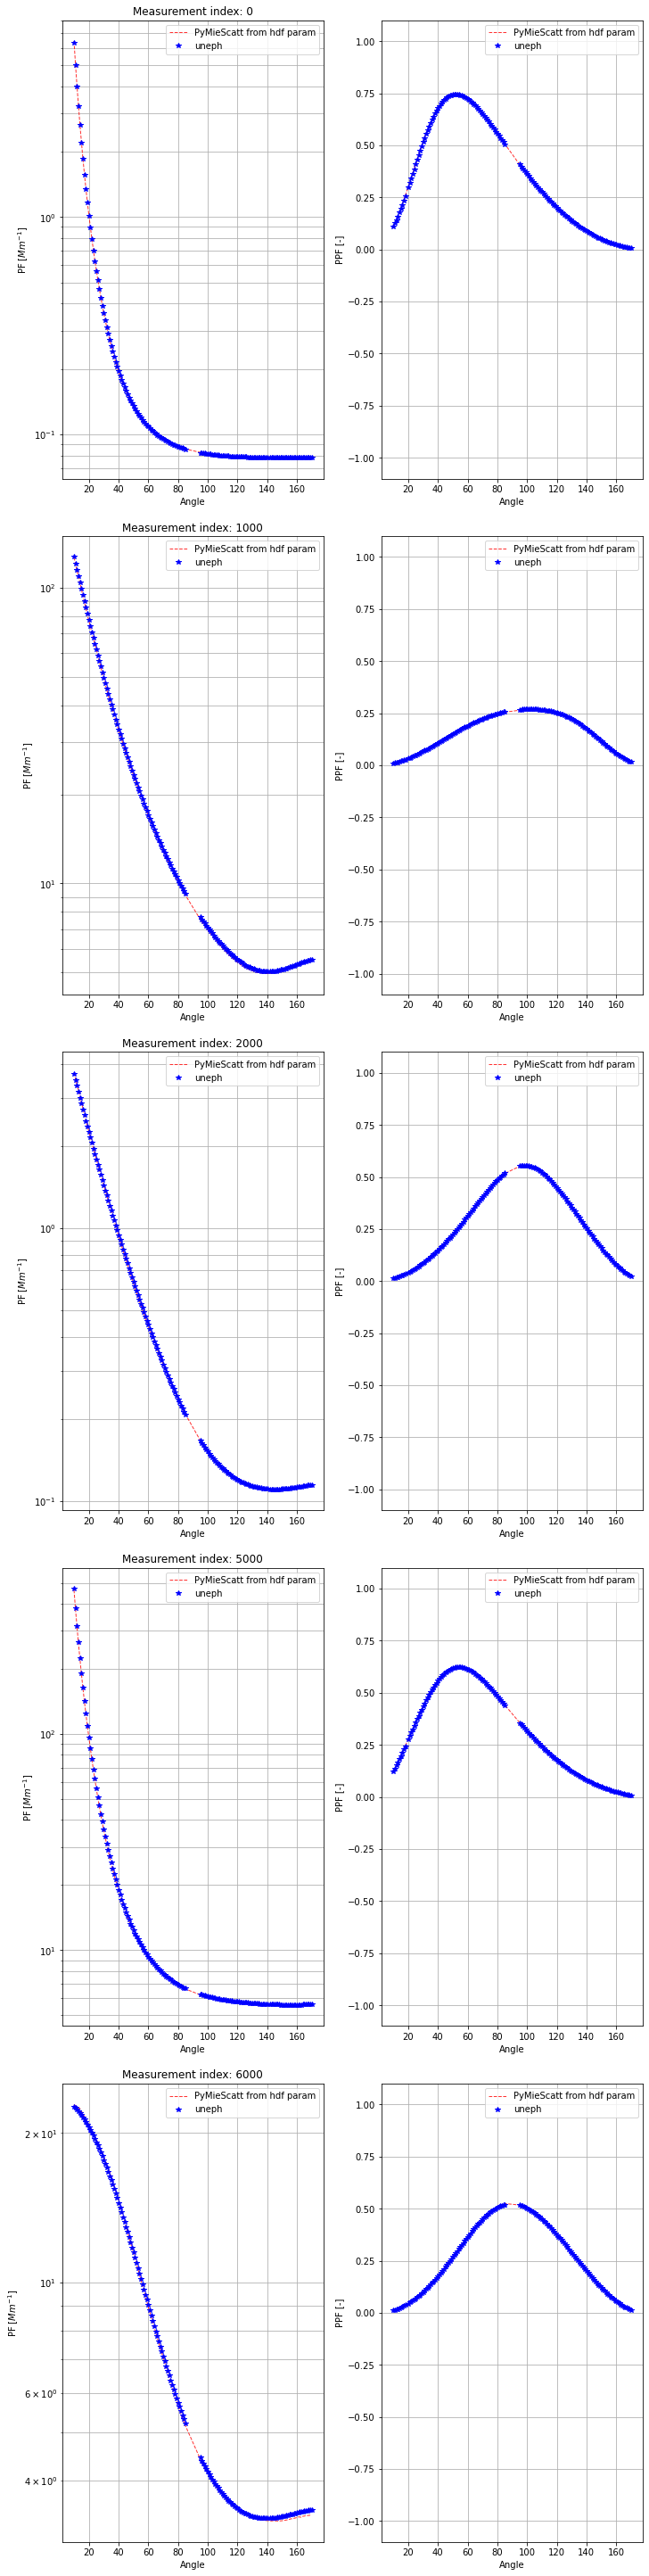

In [130]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 40), constrained_layout=True)
nr = 0
for index in presentation_plot_index:
    axs[nr,0].set_title('Measurement index: '+str(index))

    pms_hdf_plot, = axs[nr,0].plot(theta1, qoi_pred[P11_532_columns_test].loc[index], ls='--', markersize = 5, lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')
    pms_hdf_plot, = axs[nr,1].plot(theta2, qoi_pred[P12_532_columns_test].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')

    meas_hdf_plot, = axs[nr,0].plot(theta1, qoi_test[P11_532_columns_test].loc[index],'*', c= 'b', label = 'uneph')
    meas_hdf_plot, = axs[nr,1].plot(theta2, qoi_test[P12_532_columns_test].loc[index],'*', c= 'b', label = 'uneph')
    

    axs[nr,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[nr,1].set_ylabel('PPF [-]')
    axs[nr,1].set_ylim(-1.1, 1.1)
    axs[nr,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[pms_hdf_plot,meas_hdf_plot])
        ax.grid(which='both')
    nr = nr+1
fig.savefig(f'{plot_dir}/pms_meas_pred.jpg')

In [131]:
plot_dir

'/data/project/general/aerosolretriev/aerosol_results_november_2022/results_27_11_2022/forward_model_iv_2/models/plots/'

In [132]:
# Read the measurement data
#plot_dir1 = '/data/project/general/aerosolretriev/aerosol_results_november_2022/results_21_11_2022/forward_model_GSD101/models/forward_model//plots/model'

plot_dir1 = '/data/project/general/aerosolretriev/aerosol_results_november_2022/results_27_11_2022/forward_model_fw/models/plots/model'

In [158]:
measurement_pred_pms = pd.read_csv(f'{plot_dir1}/measurement_pred_pms.csv')

dvar_t1_2predict = pd.read_csv(f'{plot_dir1}/measurement_pred.csv')


In [159]:
dvar_t1_2predict = dvar_t1_2predict.drop(['Unnamed: 0'], axis = 1)

In [160]:
pymiescatt_df = pd.read_hdf('/data/project/general/aerosolretriev/aerosol_data/dataset_20_10_2022/data_meas_pms.h5',key='qoi')
datafile= '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_october2022/uneph_data_20221024_values.h5'


In [137]:
qoi_test1 = pd.read_hdf(datafile,'qoi')
dvar_test1 = pd.read_hdf(datafile,'dvar')

In [138]:
dvar_test1

Vtot  RmedianV   GSD     n       k
0   0.843577  0.100463  1.04  1.59  0.0001
1   3.096041  0.251792  1.05  1.59  0.0001
2   1.371784  0.302150  1.05  1.59  0.0001
3   3.522607  0.402867  1.05  1.59  0.0001
4   4.763140  0.503584  1.05  1.59  0.0001
5   2.220050  0.076690  1.09  1.62  0.2230
6   2.081532  0.117591  1.09  1.62  0.2230
7   2.148818  0.152689  1.08  1.62  0.2230
8   3.873357  0.178137  1.08  1.62  0.2230
9   2.463627  0.192627  1.07  1.62  0.2230
10  3.773135  0.229034  1.08  1.62  0.2230
11  2.646380  0.264661  1.08  1.62  0.2230
12  4.618050  0.304148  1.07  1.62  0.2230
13  2.002485  0.394447  1.08  1.62  0.2230

In [139]:
dvar_test1_copy = dvar_test1.copy()
dvar_test1_copy['RmedianV'] = dvar_test1_copy['RmedianV']*1e3
dvar_test1_copy['GSD']=dvar_test1_copy['GSD']-1
dvar_test1_copy['n']=dvar_test1_copy['n']-1.33
dvar_test1_copy = np.log(dvar_test1_copy)

In [140]:
dvar_t1_2predict_copy = dvar_t1_2predict.copy()

dvar_t1_2predict_copy['RmedianV'] = dvar_t1_2predict_copy['RmedianV']*1e3
dvar_t1_2predict_copy['GSD']=dvar_t1_2predict_copy['GSD']-1
dvar_t1_2predict_copy['n']=dvar_t1_2predict_copy['n']-1.33
dvar_t1_2predict_copy = np.log(dvar_t1_2predict_copy)

In [141]:
dvar_test1_copy

Vtot  RmedianV       GSD         n         k
0  -0.170104  4.609785 -3.218876 -1.347074 -9.210340
1   1.130124  5.528602 -2.995732 -1.347074 -9.210340
2   0.316112  5.710924 -2.995732 -1.347074 -9.210340
3   1.259201  5.998606 -2.995732 -1.347074 -9.210340
4   1.560907  6.221750 -2.995732 -1.347074 -9.210340
5   0.797529  4.339768 -2.407946 -1.237874 -1.500584
6   0.733104  4.767212 -2.407946 -1.237874 -1.500584
7   0.764918  5.028404 -2.525729 -1.237874 -1.500584
8   1.354122  5.182555 -2.525729 -1.237874 -1.500584
9   0.901635  5.260757 -2.659260 -1.237874 -1.500584
10  1.327906  5.433869 -2.525729 -1.237874 -1.500584
11  0.973193  5.578451 -2.525729 -1.237874 -1.500584
12  1.529973  5.717516 -2.659260 -1.237874 -1.500584
13  0.694389  5.977485 -2.525729 -1.237874 -1.500584

In [142]:
dvar_t1_2predict_copy

Vtot  RmedianV       GSD         n         k
0   0.210235  4.508196 -3.151482 -1.139119 -1.538637
1   1.020710  5.081488 -5.909338 -2.027185 -5.580272
2   0.628722  5.691122 -3.552998 -1.624353 -4.664865
3   0.849504  5.920421 -2.791426 -1.699883 -6.010378
4   0.994769  5.361551 -4.871155 -1.016839 -6.126451
5   0.406778  4.632021 -4.735900 -1.570595 -0.739075
6   0.659357  4.843698 -3.315854 -1.151033 -1.925208
7   0.723796  5.123529 -2.843970 -1.333577 -2.412443
8   1.155039  5.048674 -3.214662 -1.306463 -1.456817
9   0.820795  5.143306 -2.069392 -0.886592 -1.332982
10  1.516046  5.464130 -2.851634 -1.156050 -1.317604
11  0.999662  5.606360 -2.914950 -1.492462 -1.679078
12  1.825790  5.725300 -2.934374 -1.658144 -0.875380
13  1.585533  6.462324 -1.527446 -1.467299 -0.689302

In [144]:
qoi_test

F11_10        F11_11        F11_12        F11_13        F11_14  \
0           6.357450      4.984321      3.976080      3.220779      2.644918   
1         756.467570    685.902676    624.463388    570.621846    523.162737   
2          42.663701     41.781959     40.854722     39.889306     38.892741   
3        8044.963024   7677.963611   7331.325482   7003.987152   6694.857789   
4          15.996576     12.931267     10.301747      8.102668      6.306347   
...              ...           ...           ...           ...           ...   
200622   4888.337318   3470.038387   2532.190636   1906.504608   1482.042547   
200623  17008.696863  15731.390546  14526.519791  13398.274887  12347.864981   
200624      0.991011      0.754415      0.593133      0.478305      0.393744   
200625    194.196284    162.974897    138.184821    118.234513    101.988240   
200626     48.866585     48.374079     47.844080     47.278873     46.680834   

              F11_15        F11_16       F11_17       F11_18       F11_19  \
0           2.198950      1.848723     1.570205     1.346174     1.164100   
1         481.108506    443.664836   410.180322   380.116262   353.023718   
2          37.871705     36.832468    35.780867    34.722278    33.661613   
3        6402.874766   6126.968308  5866.114331  5619.360445  5385.801638   
4           4.870798      3.746706     2.882943     2.230527     1.745153   
...              ...           ...          ...          ...          ...   
200622   1187.229465    976.521792   821.151097   702.965158   610.449594   
200623  11374.378578  10475.443659  9647.726308  8887.301992  8189.928027   
200624      0.329800      0.280411     0.241589     0.210618     0.185587   
200625     88.619029     77.513983    68.211720    60.360025    53.686590   
200626     46.052408     45.396088    44.714397    44.009872    43.285042   

        ...   PPF_161   PPF_162   PPF_163   PPF_164   PPF_165   PPF_166  \
0       ...  0.020661  0.018675  0.016788  0.014998  0.013304  0.011706   
1       ...  0.068337  0.063213  0.058022  0.052804  0.047604  0.042464   
2       ...  0.062548  0.056812  0.051247  0.045875  0.040718  0.035796   
3       ...  0.053980  0.048672  0.043606  0.038789  0.034227  0.029927   
4       ...  0.019644  0.018876  0.018432  0.018217  0.018120  0.018022   
...     ...       ...       ...       ...       ...       ...       ...   
200622  ...  0.017990  0.016136  0.014389  0.012750  0.011218  0.009793   
200623  ...  0.032240  0.029740  0.027248  0.024774  0.022331  0.019931   
200624  ...  0.014924  0.013384  0.011930  0.010562  0.009279  0.008077   
200625  ...  0.027269  0.024901  0.022604  0.020380  0.018233  0.016168   
200626  ...  0.042345  0.038157  0.034164  0.030371  0.026782  0.023404   

         PPF_167   PPF_168   PPF_169   PPF_170  
0       0.010204  0.008796  0.007482  0.006262  
1       0.037432  0.032552  0.027870  0.023430  
2       0.031127  0.026730  0.022621  0.018817  
3       0.025895  0.022137  0.018658  0.015463  
4       0.017807  0.017374  0.016644  0.015570  
...          ...       ...       ...       ...  
200622  0.008473  0.007257  0.006141  0.005123  
200623  0.017591  0.015324  0.013149  0.011082  
200624  0.006961  0.005930  0.004985  0.004121  
200625  0.014190  0.012305  0.010519  0.008842  
200626  0.020238  0.017291  0.014565  0.012065  

[200627 rows x 302 columns]

In [146]:
qoi_pred1_copy = surr.predict(dvar_test1_copy)
qoi_pred1_copy = pd.DataFrame(data=qoi_pred1_copy, columns=qoi_test.columns)

In [147]:
qoi_t1_2pred1_copy = surr.predict(dvar_t1_2predict_copy)
qoi_t1_2pred1_copy = pd.DataFrame(data=qoi_t1_2pred1_copy, columns=qoi_test.columns)

In [148]:
qoi_t1_2pred1_copy[F11_columns]=np.exp(qoi_t1_2pred1_copy[F11_columns])
qoi_pred1_copy[F11_columns] = np.exp(qoi_pred1_copy[F11_columns])



In [149]:
F11_list_test = [x for x in qoi_test1.columns if 'F11' in x]
PPF_list_test = [x for x in qoi_test1.columns if 'PPF' in x]

In [150]:
F11_columns

['F11_10',
 'F11_11',
 'F11_12',
 'F11_13',
 'F11_14',
 'F11_15',
 'F11_16',
 'F11_17',
 'F11_18',
 'F11_19',
 'F11_20',
 'F11_21',
 'F11_22',
 'F11_23',
 'F11_24',
 'F11_25',
 'F11_26',
 'F11_27',
 'F11_28',
 'F11_29',
 'F11_30',
 'F11_31',
 'F11_32',
 'F11_33',
 'F11_34',
 'F11_35',
 'F11_36',
 'F11_37',
 'F11_38',
 'F11_39',
 'F11_40',
 'F11_41',
 'F11_42',
 'F11_43',
 'F11_44',
 'F11_45',
 'F11_46',
 'F11_47',
 'F11_48',
 'F11_49',
 'F11_50',
 'F11_51',
 'F11_52',
 'F11_53',
 'F11_54',
 'F11_55',
 'F11_56',
 'F11_57',
 'F11_58',
 'F11_59',
 'F11_60',
 'F11_61',
 'F11_62',
 'F11_63',
 'F11_64',
 'F11_65',
 'F11_66',
 'F11_67',
 'F11_68',
 'F11_69',
 'F11_70',
 'F11_71',
 'F11_72',
 'F11_73',
 'F11_74',
 'F11_75',
 'F11_76',
 'F11_77',
 'F11_78',
 'F11_79',
 'F11_80',
 'F11_81',
 'F11_82',
 'F11_83',
 'F11_84',
 'F11_85',
 'F11_95',
 'F11_96',
 'F11_97',
 'F11_98',
 'F11_99',
 'F11_100',
 'F11_101',
 'F11_102',
 'F11_103',
 'F11_104',
 'F11_105',
 'F11_106',
 'F11_107',
 'F11_108',
 

In [152]:
theta_meas = []
for i in range(10,86):
    theta_meas.append(i)
for i in range(95,171):
    theta_meas.append(i)

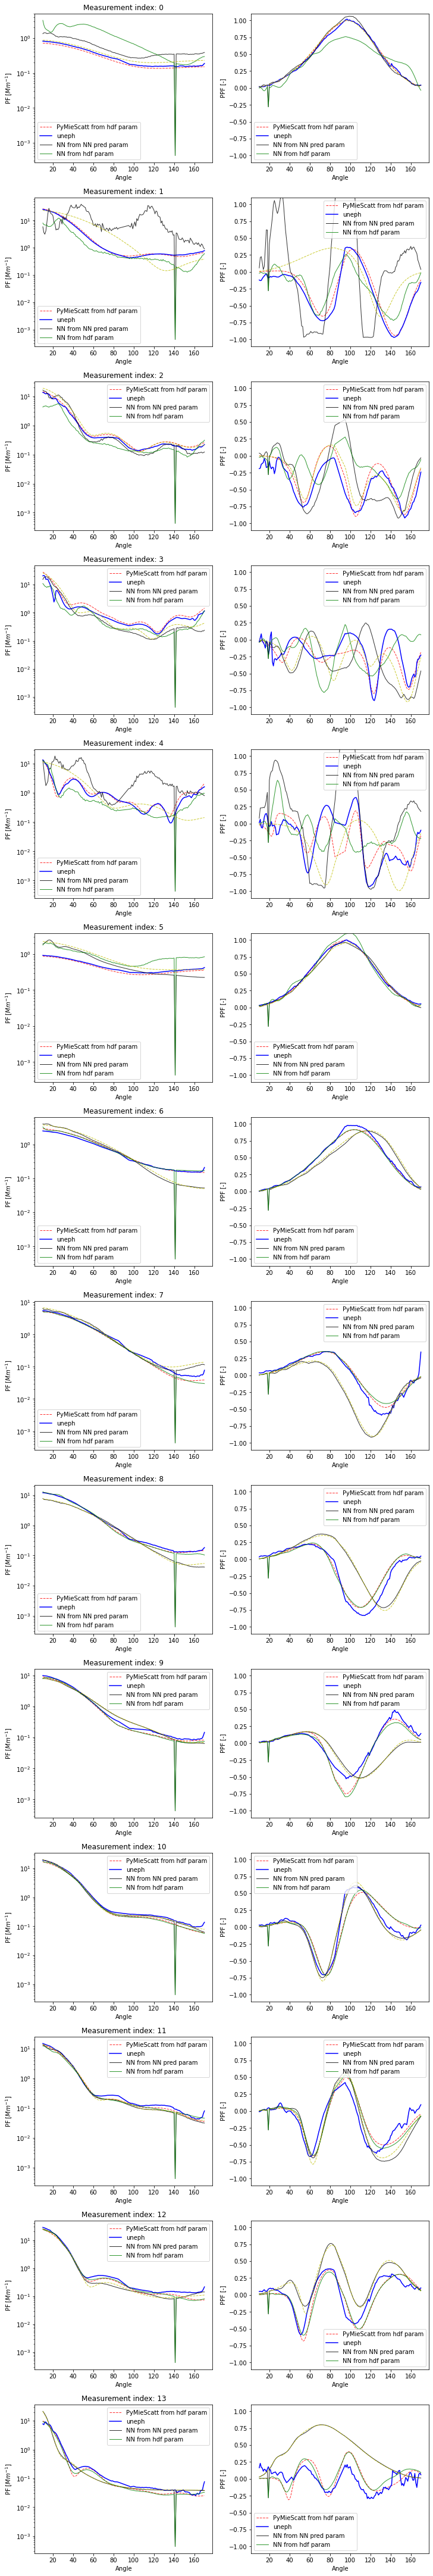

In [162]:
fig, axs = plt.subplots(ncols=2, nrows=14, figsize=(10, 60), constrained_layout=True)
for index in range(14):
    axs[index,0].set_title('Measurement index: '+str(index))

    pms_hdf_plot, = axs[index,0].plot(theta, pymiescatt_df[F11_columns].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')
    pms_hdf_plot, = axs[index,1].plot(theta, pymiescatt_df[PPF_columns].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')

    meas_hdf_plot, = axs[index,0].plot(theta_meas, qoi_test1[F11_list_test].loc[index].values/4/np.pi, c= 'b', label = 'uneph')
    meas_hdf_plot, = axs[index,1].plot(theta_meas, qoi_test1[PPF_list_test].loc[index].values, c= 'b', label = 'uneph')
    
    pms_pred_plot, = axs[index,0].plot(theta, qoi_t1_2pred1_copy[F11_columns].loc[index], lw='1', c='k', alpha=0.8, label='NN from NN pred param')
    pms_pred_plot, = axs[index,1].plot(theta, qoi_t1_2pred1_copy[PPF_columns].loc[index], lw='1', c='k', alpha=0.8, label='NN from NN pred param')

    pms_pred_plot1, = axs[index,0].plot(theta, qoi_pred1_copy[F11_columns].loc[index],  lw='1', c='g', alpha=0.8, label='NN from hdf param')
    pms_pred_plot1, = axs[index,1].plot(theta, qoi_pred1_copy[PPF_columns].loc[index],  lw='1', c='g', alpha=0.8, label='NN from hdf param')

    
    pms_pred_plot2, = axs[index,0].plot(theta, measurement_pred_pms[F11_columns].loc[index], ls='--', lw='1', c='y', alpha=0.8, label='PyMieScatt from NN pred param')
    pms_pred_plot2, = axs[index,1].plot(theta, measurement_pred_pms[PPF_columns].loc[index], ls='--', lw='1', c='y', alpha=0.8, label='PyMieScatt from NN pred param')

    
    axs[index,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index,1].set_ylabel('PPF [-]')
    axs[index,1].set_ylim(-1.1, 1.1)
    axs[index,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[pms_hdf_plot,meas_hdf_plot, pms_pred_plot,pms_pred_plot1])#,pms_pred_plot2])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/pms_meas_pred_new.jpg')


In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=14, figsize=(10, 60), constrained_layout=True)
for index in range(14):
    axs[index,0].set_title('Measurement index: '+str(index))

    pms_hdf_plot, = axs[index,0].plot(theta, pymiescatt_df[F11_columns].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')
    pms_hdf_plot, = axs[index,1].plot(theta, pymiescatt_df[PPF_columns].loc[index], ls='--', lw='1', c='r', alpha=0.8, label='PyMieScatt from hdf param')

    meas_hdf_plot, = axs[index,0].plot(theta_meas, qoi_test1[F11_list_test].loc[index].values/4/np.pi, c= 'b', label = 'uneph')
    meas_hdf_plot, = axs[index,1].plot(theta_meas, qoi_test1[PPF_list_test].loc[index].values, c= 'b', label = 'uneph')
    
    pms_pred_plot, = axs[index,0].plot(theta, qoi_t1_2pred1_copy[F11_columns].loc[index], lw='1', c='k', alpha=0.8, label='NN from INN pred param')
    pms_pred_plot, = axs[index,1].plot(theta, qoi_t1_2pred1_copy[PPF_columns].loc[index], lw='1', c='k', alpha=0.8, label='NN from INN pred param')

    
    pms_pred_plot2, = axs[index,0].plot(theta, measurement_pred_pms[F11_columns].loc[index], ls='--', lw='1', c='y', alpha=0.8, label='PyMieScatt from INN pred param')
    pms_pred_plot2, = axs[index,1].plot(theta, measurement_pred_pms[PPF_columns].loc[index], ls='--', lw='1', c='y', alpha=0.8, label='PyMieScatt from INN pred param')

    
    axs[index,0].set_ylabel('PF [$Mm^{-1}$]')
    axs[index,1].set_ylabel('PPF [-]')
    axs[index,1].set_ylim(-1.1, 1.1)
    axs[index,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[pms_hdf_plot,meas_hdf_plot, pms_pred_plot,pms_pred_plot2])
        ax.grid(which='both')
fig.savefig(f'{plot_dir}/pms_meas_pred_new.jpg')


### Plot for Particle Radius Distribution

KeyError: 'CMR_fine'

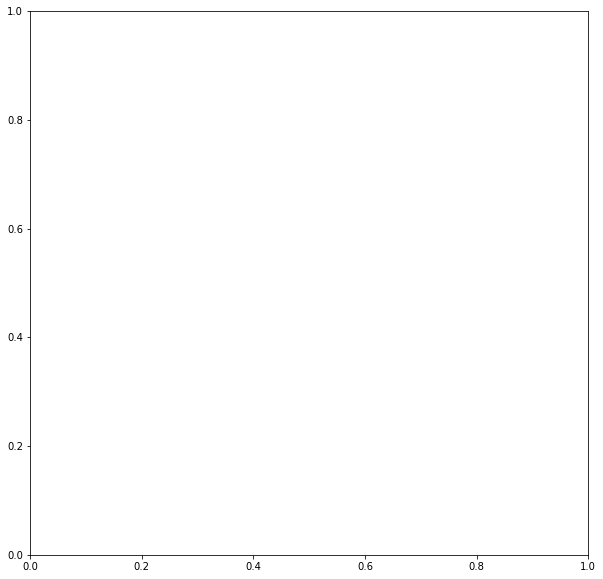

In [112]:
fig, ax = plt.subplots(figsize = (10,10));

x1data = []
x2data = []
y1data = []
y2data = []

for datapoint in presentation_plot_index:
    

    mu1 = [qoi_pred.iloc[datapoint]['CMR_fine'], qoi_pred.iloc[datapoint]['CMR_coarse']]
    sigma1 = [qoi_pred.iloc[datapoint]['GSD_fine'], qoi_pred.iloc[datapoint]['GSD_coarse']]
    mu2 = [qoi_test.iloc[datapoint]['CMR_fine'], qoi_test.iloc[datapoint]['CMR_coarse']]
    sigma2 = [qoi_test.iloc[datapoint]['GSD_fine'], qoi_test.iloc[datapoint]['GSD_coarse']]
    Vtot1 = qoi_pred.iloc[datapoint]['V_tot']
    Vtot2 = qoi_test.iloc[datapoint]['V_tot']
    
    x1 = np.linspace(min(bins1), max(bins1), 100000)
    x2 = np.linspace(min(bins2), max(bins2), 100000)
    
    pdf1 = [(Vtot1 / (np.sqrt(2 * np.pi) * np.log(sigma1[0]))) * np.exp((-np.square((np.log(x) - np.log(mu1[0])))) / (2 * np.square(np.log(sigma1[0])))) +
             (Vtot1 / (np.sqrt(2 * np.pi) * np.log(sigma1[1]))) * np.exp((-np.square((np.log(x) - np.log(mu1[1])))) / (2 * np.square(np.log(sigma1[1])))) for x in x1]
    
            
    pdf2 = [(Vtot2 / (np.sqrt(2 * np.pi) * np.log(sigma2[0]))) * np.exp((-np.square((np.log(x) - np.log(mu2[0])))) / (2 * np.square(np.log(sigma2[0])))) +
             (Vtot2 / (np.sqrt(2 * np.pi) * np.log(sigma2[1]))) * np.exp((-np.square((np.log(x) - np.log(mu2[1])))) / (2 * np.square(np.log(sigma2[1])))) for x in x2]
    

    
    x1data.append(x1)
    x2data.append(x2)
    y1data.append(pdf1)
    y2data.append(pdf2)


In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
for datalen in (0,1,2,3):
    print(presentation_plot_index[datalen])
     
    if datalen == 0:        
        ax.plot(x1data[datalen], y1data[datalen],'b', linewidth=2,label ='Retrieved test data', zorder = 5)
        ax.plot(x2data[datalen], y2data[datalen], '*g',linewidth=1, label = 'Simulated test data', zorder = 0)
    else:
        ax.plot(x1data[datalen], y1data[datalen],'b', linewidth=2 , zorder = 5)#,label ='Retrieved test data')
        ax.plot(x2data[datalen], y2data[datalen], '*g',linewidth=1, zorder = 0)#, label = 'Simulated test data')
        
    
ax.legend(['Predicted test data', 'test data'], fontsize = 16)
ax.legend(fontsize = 16)   

ax.set_xlabel('Particle Radius [$\mu$m]',fontsize = 25)
ax.set_ylabel('Concentration ',fontsize = 25)
ax.tick_params(labelsize = 16)    
ax.set_title( 'Comparison Simulation and Prediction',fontsize = 25)
fig.align_labels()

plt.xscale('log')

In [ ]:
wl = ['450', '532','630']
wl_P11_450 = []
wl_P11_532 = []
wl_P11_630 = []
wl_P12_450 = []
wl_P12_532 = []
wl_P12_630 = []
for key in qoi_columns:
    if 'P11_0.450' in key:
        wl_P11_450.append(key)
    elif 'P11_0.532' in key:
        wl_P11_532.append(key)
    elif 'P11_0.630' in key:
        wl_P11_630.append(key)
    elif 'P12_0.450' in key:
        wl_P12_450.append(key)
    elif 'P12_0.532' in key:
        wl_P12_532.append(key)
    elif 'P12_0.630' in key:
        wl_P12_630.append(key)

In [ ]:
wl_list_P11 = [wl_P11_450,wl_P11_532,wl_P11_630]

In [ ]:
wl_list_P12 = [wl_P12_450, wl_P12_532, wl_P12_630]

In [ ]:
for wl_item in wl_list_P11:
    if len(wl_item) != 0:
        fig, ax = plt.subplots(figsize = (10,10))
        for index in presentation_plot_index:
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_test[wl_item].iloc[index],'b*')
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_pred[wl_item].iloc[index],'r.')

        ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
        ax.set_ylabel('log(P11)[$m^{-1}sr^{-1}$]',fontsize = 25)
        ax.tick_params(labelsize = 16)    
        fig.tight_layout() 
        ax.set_title( 'Comparison Test and Prediction'+wl_item[0],fontsize = 25)
        ax.legend(['test data', 'predicted test data'], fontsize = 16)
        fig.savefig(f'{plot_dir}/phase_data__result_iv'+str(wl_item[0])+'.jpg')

In [ ]:
for wl_item in wl_list_P12:
    if len(wl_item) != 0:
        fig, ax = plt.subplots(figsize = (10,10))
        for index in presentation_plot_index:
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_test[wl_item].iloc[index],'b*')
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_pred[wl_item].iloc[index],'r.')
    
    

        ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
        ax.set_ylabel('P11\P12',fontsize = 25)
        ax.tick_params(labelsize = 16)    
        fig.tight_layout() 
        ax.set_title( 'Comparison Test and Prediction'+wl_item[0],fontsize = 25)
        ax.legend(['test data', 'predicted test data'], fontsize = 16)
        fig.savefig(f'{plot_dir}/phase_data__result_iv'+str(wl_item[0])+'.jpg')

## correlation plots

In [ ]:
for index in presentation_plot_index:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(qoi_pred.iloc[index],qoi_test.iloc[index],'g*')
    ax.plot(qoi_test.iloc[index],qoi_test.iloc[index],'r')
    ax.set_title('qoi'+str(index), fontsize = 25)
    ax.set_xlabel('test data',fontsize = 25)
    ax.set_ylabel('predicted test data',fontsize = 25)

## Plot R2 

In [ ]:
r2_adj

In [ ]:
fig, ax = plt.subplots(figsize=(16, 1.5), dpi=400)

sns.heatmap(r2_adj,
            cmap='Reds',
       #     annot=False,
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
      #      annot_kws={'fontsize': 20},
#            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()
ax.set_ylabel('r2_adj')
# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

#fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/forward_model_r2_adj.jpg')


## Plot Relative / Absolute Errors 

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table_P11,
            cmap='Reds',
            #annot=True,
            linewidths=0.02,
            vmin=0.,
            vmax=np.max(rel_error_table.max()),
            #annot_kws={'fontsize': 10},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=10);
fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/isodar_forward_rel_error_percentiles_P11.jpg')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(abs_error_table_P12,
            cmap='Reds',
            #annot=True,
            linewidths=0.02,
            vmin=0.,
            vmax=np.max(rel_error_table.max()),
            #annot_kws={'fontsize': 10},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=10);
fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/isodar_forward_rel_error_percentiles_P12.jpg')

# Further plots
## DVARs vs. percentage errors

In [ ]:
def plot_error_vs_dvar(design_var):
    fig, axes = plt.subplots(4, 3, figsize=(16, 27))


    for i, col in enumerate(qoi_test.columns[0:12]):
        ax = axes.flatten()[i]

        ax.plot(dvar_test[design_var],
                rel_error[col],
                'o');

        ax.hlines(y=0.,
                  xmin=dvar_test[design_var].min(),
                  xmax=dvar_test[design_var].max(),
                  color='red',
                  zorder=3)

        ax.set_xlabel(design_var, fontsize=20)
        ax.set_ylabel(r'$\Delta$' + col + r' [%]', fontsize=20)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        

    fig.tight_layout()
    fig.savefig(f'{plot_dir}/percentage_error_vs_{design_var}.jpg')
    
    return fig

In [ ]:
qoi_test.columns[0:11]

In [ ]:
for d in dvar_test.columns:
    plot_error_vs_dvar(d)

## Correlations between DVARs and QOIs

In [ ]:
combined = pd.concat([dvar_test, rel_error], axis=1)

In [ ]:
corr = np.round(combined.corr(), decimals=2)

In [ ]:
to_plot = corr.copy()
to_plot.drop(columns=dvar_test.columns, inplace=True)
#to_plot.rename(columns=qoi.columns, index=qoi.columns.values, inplace=True)

In [ ]:
to_plot = to_plot.drop(qoi_test.columns, axis =0)

In [ ]:
to_plot

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

sns.heatmap(to_plot,
            vmin=-1.,
            vmax=1.,
            cmap='coolwarm',
            linewidths=0.01,
           # annot=True,
            ax=ax)
ax.tick_params(axis='y', rotation=0)
ax.tick_params(axis='both', length=0, labelsize=10)

fig.tight_layout()
fig.savefig(f'{plot_dir}/rel_error_correlations.jpg')

## Residuals

In [113]:
colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(16, 9))
for col in qoi_test.columns[0:3]:
    sns.distplot(abs_error[col], ax=ax)
ax.text(x=-0.025,
        y=5,
        color=colors[5],
        s=r'$phase_0.0$',
        fontsize=30)
ax.text(x=0.015,
        y=3,
        color=colors[6],
        s=r'$phase_1.0$',
        fontsize=30)
ax.text(x=0.01,
        y=4,
        color=colors[7],
        s=r'$phase_2.0$',
        fontsize=30)
ax.set_xlabel('Residuals [mm]', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=18)

fig.savefig(f'{plot_dir}/residual_distr_sigma.jpg')

/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

ValueError: Image size of 979x253463 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1152x648 with 1 Axes>

colors = sns.color_palette()

fig, ax = plt.subplots(figsize=(16, 9))
for col in qoi.columns:
    sns.distplot(error[col], ax=ax)
#ax.text(x=-0.025,
#        y=15,
#        color=colors[0],
#        s=r'$\sigma_x$',
#        fontsize=30)
#ax.text(x=0.015,
#        y=30,
#        color=colors[1],
#        s=r'$\sigma_y$',
#        fontsize=30)
#ax.text(x=0.01,
#        y=40,
#        color=colors[2],
#        s=r'$\sigma_z$',
#        fontsize=30)
ax.set_xlabel('Residuals [mm]', fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(labelsize=18)

fig.savefig(f'{plot_dir}/residual_distr_sigma.jpg')

In [114]:
def standardise(x):
    return (x - x.mean()) / x.std()

In [115]:
for i, col in enumerate(qoi_test.columns[0:11]):
    print(i)
    print(col)

0
F11_10
1
F11_11
2
F11_12
3
F11_13
4
F11_14
5
F11_15
6
F11_16
7
F11_17
8
F11_18
9
F11_19
10
F11_20


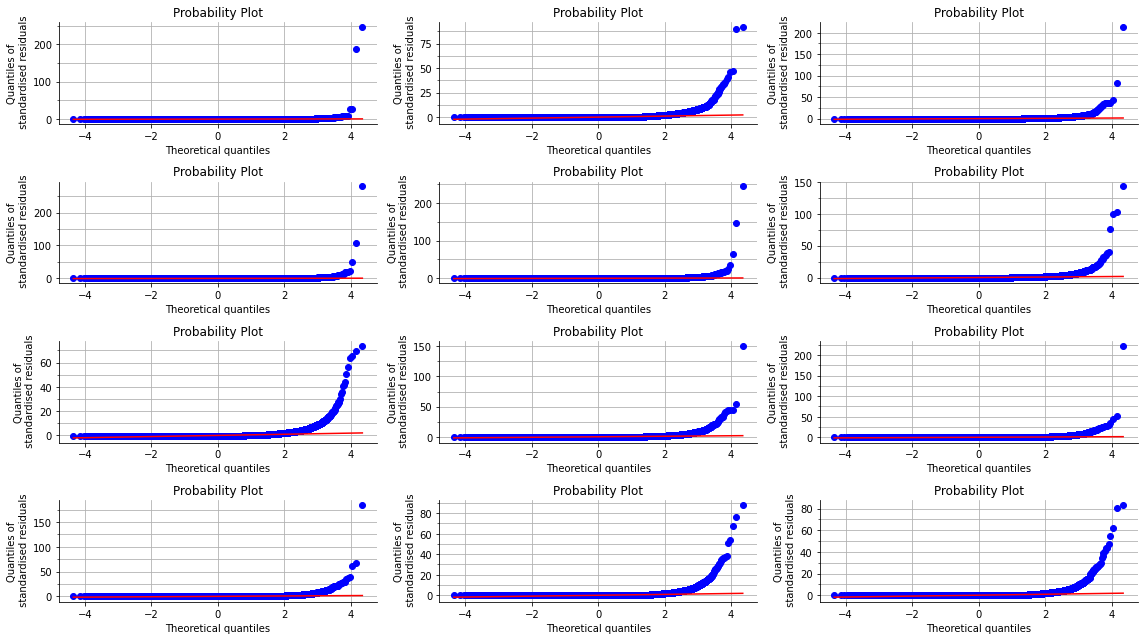

In [116]:
fig, axes= plt.subplots(4, 3, figsize=(16, 9))

for i, col in enumerate(qoi_test.columns[0:12]):
    ax = axes.flatten()[i]
    scipy.stats.probplot(standardise(abs_error[col]), dist="norm", plot=ax);
#    ax.set_title(qoi.columns[col], fontsize=20)
    ax.set_ylabel('Quantiles of\n standardised residuals')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True)
    ax.grid(True, which='minor')
    #ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

fig.tight_layout()
fig.savefig(f'{plot_dir}/residual_normality_plots.jpg')

In [117]:
# pd.DataFrame({'Mean': error.mean(axis=0), 'std': error.std(axis=0)})

In [118]:
statistic, p = scipy.stats.shapiro(standardise(abs_error[qoi_test.columns[0]]).values)

/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [119]:
statistic

0.015301644802093506

In [ ]:
p

In [ ]:
surr.model.summary()

In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
plot_dir

In [ ]:
plot_model(surr.model, show_shapes=True,show_layer_names=True, to_file = f'{plot_dir}/model_architecture.png')


NameError: name 'r2_adj' is not defined

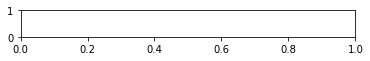

In [27]:
# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(7,3)

plt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)
sns.heatmap(r2_adj,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            xticklabels= False)
plt.tick_params(labelsize = 16)    
plt.title( 'Adjusted R2',fontsize = 25)

plt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)
sns.heatmap(rel_error_table,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=np.max(rel_error_table.max()),
            xticklabels = False,
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'})
plt.tick_params(labelsize = 16)    
plt.title( 'Relative Error',fontsize = 25)


plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)
sns.heatmap(to_plot,
            vmin=-1.,
            vmax=1.,
            linewidths = 0.01,
            cmap='coolwarm',)
plt.tick_params(labelsize = 16)
plt.title( 'Correlation between DVARs and QOIs',fontsize = 25)

plt.subplot2grid((7,3), (5,0), colspan = 2, rowspan = 2)
for index in presentation_plot_index:
    plot_test_data = plt.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = plt.plot(np.arange(3,len(qoi_pred.columns)+3),qoi_pred.iloc[index],'r.')
plt.xlabel('Scattering angle (degrees)',fontsize = 25)
plt.ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
plt.legend(['Test data', 'Predicted test data'], fontsize = 16)
#get_legend().get_title().set_fontsize('16')


plt.subplot2grid((7,3), (5,2), colspan = 1, rowspan = 1)
for index in qoi_test.index.values:
    plt.plot(qoi_test.iloc[index],qoi_pred.iloc[index],'b*')
plt.title( 'Comparison Test and Prediction',fontsize = 25)    
plt.xlabel('Test data',fontsize = 25)
plt.ylabel('Predicted test data ',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.axline([-25, -25], [-8, -8])


fig.set_size_inches(w=30,h=30)
fig.savefig(f'{plot_dir}/overview_forward_model.jpg')


# Store results

In [128]:
configs = pd.read_csv(f'{model_dir}/configs.csv')
configs.columns

Index(['Unnamed: 0', 'MAE_train', 'MAE_val', 'MAPE_train', 'MAPE_val',
       'MSE_train', 'MSE_val', 'median_percentile_max_error_train',
       'median_percentile_max_error_val', '90_percentile_max_error_train',
       '90_percentile_max_error_val', 'r2_train', 'r2_val', 'r2_adj_train',
       'r2_adj_val', 'time_this_iter_s', 'done', 'timesteps_total',
       'episodes_total', 'training_iteration', 'experiment_id', 'date',
       'timestamp', 'time_total_s', 'pid', 'hostname', 'node_ip',
       'time_since_restore', 'timesteps_since_restore',
       'iterations_since_restore', 'trial_id', 'experiment_tag',
       'config/batch_size', 'config/datafile', 'config/depth', 'config/lr',
       'config/width', 'logdir'],
      dtype='object')

In [117]:
store_results = pd.DataFrame()

In [130]:
if 'P11' in qoi_columns[0]:
    store_results['rel_error95%_qoi_P11_max'] = rel_error_table_P11.max(axis = 1)['95%']
    store_results['abs_error95%_qoi_P11_max'] = abs_error_table_P11.max(axis = 1)['95%']
else:
    store_results['rel_error95%_qoi_P11_max'] = 0
    store_results['abs_error95%_qoi_P11_max'] = 0
if 'P12' in qoi_columns[-1]:
    store_results['rel_error95%_qoi_P12_max'] = rel_error_table_P12.max(axis = 1)['95%']
    store_results['abs_error95%_qoi_P12_max'] = abs_error_table_P12.max(axis = 1)['95%']
else:    
    store_results['rel_error95%_qoi_P12_max'] = 0
    store_results['abs_error95%_qoi_P12_max'] = 0
store_results['MAE_qoi_max'] = MAE_all_qoi.max(axis= 1).values
store_results['MAPE%_qoi_max'] = MAPE_all_qoi.max(axis= 1).values
store_results['explained_variance_qoi_min'] = EVS_all_df.min(axis = 1)





store_results['preprocessor_x'] = configs['config/preprocessor_x']
store_results['preprocessor_y'] = configs['config/preprocessor_y']

KeyError: 'config/preprocessor_x'

In [129]:
store_results['data_file'] = configs['config/datafile']
store_results['batch_size'] = configs['config/batch_size']
store_results['learning_rate'] = configs['config/lr']

store_results['n_depth'] = configs['config/n_depth']
store_results['n_width'] = configs['config/n_width']

KeyError: 'config/learning_rate'

In [125]:
store_results

rel_error95%_qoi_P11_max  abs_error95%_qoi_P11_max  \
0                      0.76                      0.17   

   rel_error95%_qoi_P12_max  abs_error95%_qoi_P12_max  MAE_qoi_max  \
0                         0                         0     0.066191   

   MAPE%_qoi_max  explained_variance_qoi_min  
0       0.002976                    0.997857